<a href="https://colab.research.google.com/github/rmoberly91/Sentiscope_Repo/blob/main/sentiscope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#utilities
import re
import numpy as np
import pandas as pd
import pickle

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc


#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#warnings
import warnings
warnings.filterwarnings('ignore')

#Data import
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


,text
799995,sick spending my day laying in bed listening ...
799996,gmail is down?
799997,rest in peace farrah! so sad
799998,@eric_urbane sounds like a rival is flagging y...
799999,has to resit exams over summer... wishes he w...


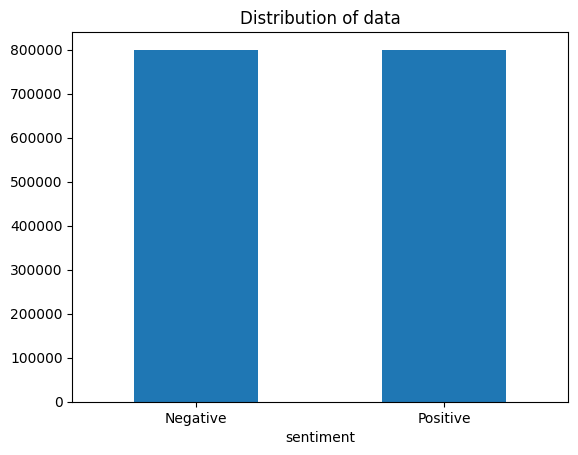

In [ ]:
#Import dataset

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv("twitter_data140.csv", encoding=DATASET_ENCODING,
                      names=DATASET_COLUMNS, engine = "python")

#What we care about is the Sentiment, everything else is not super important
dataset = dataset[['sentiment','text']]

#Replacing "4" with "1" in the sentiment portion of the data
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

#Visualization of the dataset
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

#Create lists for our dataset
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

#Checking for unique values in the sentiment column
dataset['sentiment'].unique()

#Setting our positive and negative
data_pos = dataset[dataset['sentiment'] == 1]
data_neg = dataset[dataset['sentiment'] == 0]

#Combining positive and negative sets together for easy use
dataset = pd.concat([data_pos, data_neg])

#Forcing the text in the dataset to lowercase
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

In [ ]:
#Remove Usernames
#Search for regular expressions with a @ at the beginning
#Then we just remove those regular expressions. Simple!

def remove_usernames(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    return tweet
dataset['text'] = dataset['text'].apply(lambda x: remove_usernames(x))
dataset['text'].tail()

,text
799995,sick spending my day laying in bed listening to
799996,gmail is down?
799997,rest in peace farrah! so sad
799998,sounds like a rival is flagging your ads. not...
799999,has to resit exams over summer... wishes he w...


In [ ]:
#Removing URLS from our dataset
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

,text
799995,sick spending my day laying in bed listening to
799996,gmail is down?
799997,rest in peace farrah! so sad
799998,sounds like a rival is flagging your ads. not...
799999,has to resit exams over summer... wishes he w...


In [ ]:
#Removing numbers from the dataset
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

,text
799995,sick spending my day laying in bed listening to
799996,gmail is down?
799997,rest in peace farrah! so sad
799998,sounds like a rival is flagging your ads. not...
799999,has to resit exams over summer... wishes he w...


In [ ]:
#Stop Words detection
#Stop Words are words that are going to be irrelevant for our use
#So we just remove them here.

", ".join(stopwords.words('english'))

stopwords_list = stopwords.words('english')

STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

,text
800000,love u guys r best!!
800001,im meeting one besties tonight! cant wait!! - ...
800002,"thanks twitter add, sunisa! got meet hin show ..."
800003,sick really cheap hurts much eat real food plu...
800004,effect everyone


In [ ]:
#Removing Punctuation
#Punctuation creates a big problem, so we remove it

import string

english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

,text
799995,sick spending day laying bed listening
799996,gmail down
799997,rest peace farrah sad
799998,sounds like rival flagging ads much though
799999,resit exams summer wishes worked harder first ...


In [ ]:
#Stemmer - pulling words out by the stem
#The basic root of the word

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

,text
800000,love u guys r best
800001,im meeting one besties tonight cant wait girl...
800002,thanks twitter add sunisa got meet hin show dc...
800003,sick really cheap hurts much eat real food plu...
800004,effect everyone


In [ ]:
#Lemmatizer - makes lemons
#Reduces words to their lemma, the essence of the word

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

,text
800000,love u guys r best
800001,im meeting one besties tonight cant wait girl...
800002,thanks twitter add sunisa got meet hin show dc...
800003,sick really cheap hurts much eat real food plu...
800004,effect everyone


In [ ]:
#Splitting up data for validation and training
X_Train, X_Test, y_train, y_test = train_test_split(dataset['text'], dataset['sentiment'], test_size=0.25, random_state=42)

In [ ]:
#Fitting the TFID Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_Train)
#print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
#Using vectorizer data
X_train = vectoriser.transform(X_Train)
X_test  = vectoriser.transform(X_Test)

In [ ]:
#Evaluate the model and see if it works!
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    200419
           1       0.78      0.81      0.80    199581

    accuracy                           0.79    400000
   macro avg       0.79      0.79      0.79    400000
weighted avg       0.79      0.79      0.79    400000



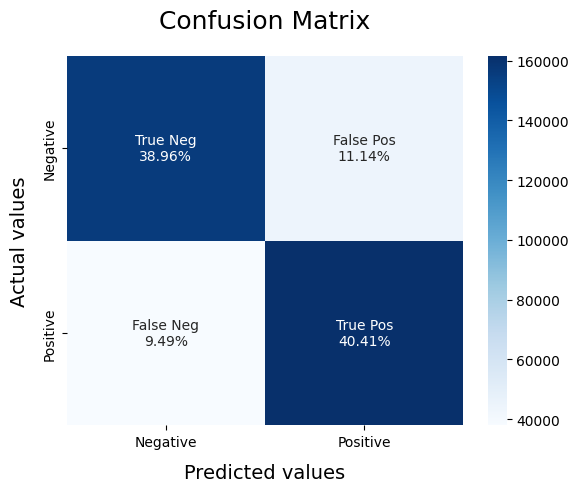

In [ ]:
#Boilerplate Logistic Regression
LRmodel = LogisticRegression(solver='lbfgs')
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred = LRmodel.predict(X_test)

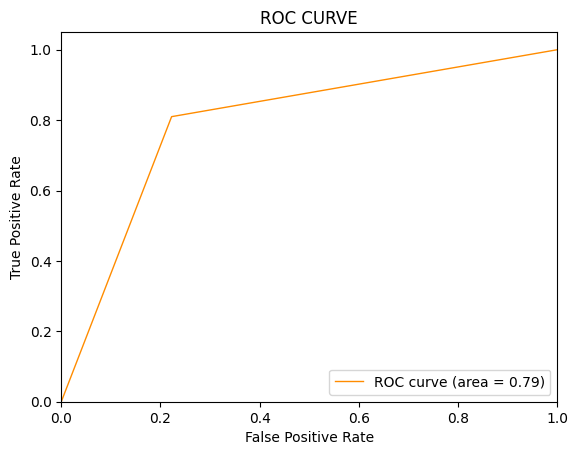

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def remove_reddit_usernames(post):
    post = re.sub('u/[^\s]+','',post)
    post = re.sub('r/[^\s]+', '',post)
    return post
dataset['text'] = dataset['text'].apply(lambda x: remove_usernames(x))
dataset['text'].tail()

In [ ]:
#dataset input

def use_model(data):
  data['text'] = data['text'].apply(lambda x: x.lower())
  data['body'] = data['body'].apply(lambda x: remove_reddit_usernames(x))
  data['body'] = data['body'].apply(lambda x: cleaning_URLs(x))
  data['body'] = data['body'].apply(lambda x: cleaning_numbers(x))
  data['body'] = data['body'].apply(lambda x: cleaning_stopwords(x))
  data['body'] = data['body'].apply(lambda x: cleaning_punctuations(x))
  data['body'] = data['body'].apply(lambda x: stemming_on_text(x))
  data['body'] = data['body'].apply(lambda x: lemmatizer_on_text(x))

  data = vectoriser.transform(data['body'])
  return data

In [ ]:
filename = '/content/drive/MyDrive/sentiscope.pkl'
pickle.dump(LRmodel, open(filename, 'wb'))